In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
df = pd.read_csv('Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [5]:
df = df.sample(frac = 1)

from sklearn.model_selection import train_test_split
text = df['Text'].values
label = df['Sentiment'].values
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.20, random_state=20)

In [6]:
df.head()

,Text,Sentiment
2064,OMX another bricks and mortar dinosaur falling...,-1
5305,Many merchants still ask customers to sign for...,-1
3875,OI SO XOM CPE IG -How does the price of oil Ve...,1
168,NVDA 4 hour - love to see the vol explode.,1
382,"ANA with the conference tomorrow, I guess we w...",1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 2064 to 3395
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 135.7+ KB


# One hot embedding + CNN

In [8]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(text_train)
 Xcnn_train = tokenizer.texts_to_sequences(text_train)
 Xcnn_test = tokenizer.texts_to_sequences(text_test)
 vocab_size = len(tokenizer.word_index)+1
 print(text_train[1])
 print(Xcnn_train[1]) 

STI 30 min opening range busta move. 2 first target. Calls  
[2821, 113, 289, 592, 407, 4023, 65, 32, 165, 128, 173]


In [9]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 150
 Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
 Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
 print(Xcnn_train[0, :]) 

[4022  274    2  280  742  798  382   19 1547  560 1096  620  288  436
 1814  357   32  145    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [10]:
from keras.models import Sequential
from keras import layers 
import tensorflow as tf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          1798000   
                                                                 
 conv1d (Conv1D)             (None, 149, 256)          102656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 128)           98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 33, 64)            3

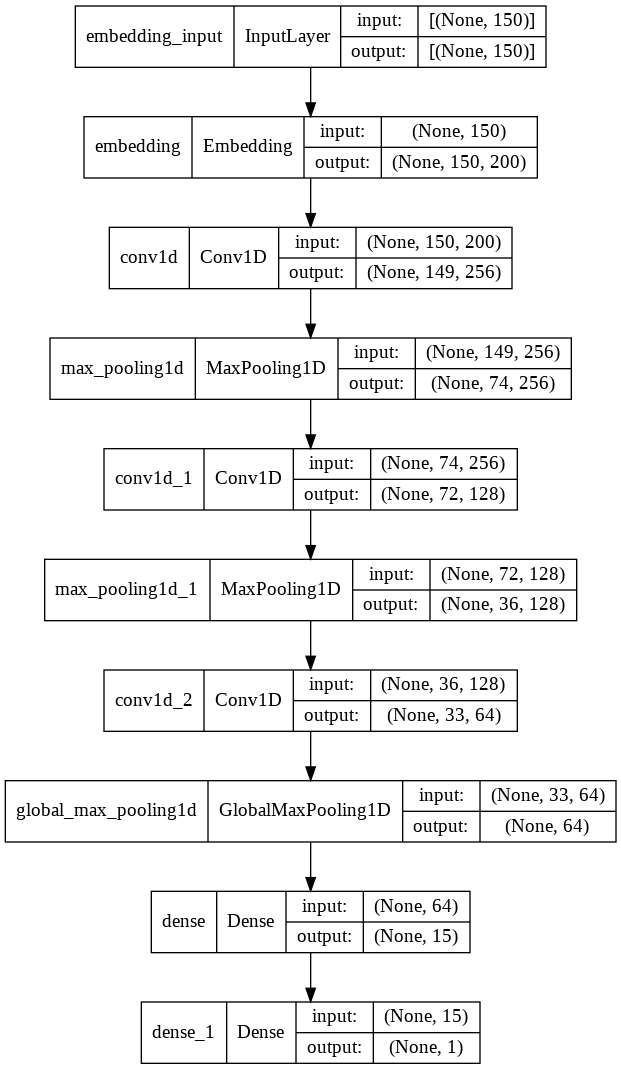

In [11]:
seed = 170204054
torch.manual_seed(seed)
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(15, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
textcnnmodel.summary() 

tf.keras.utils.plot_model(textcnnmodel, show_shapes = True, show_layer_names = True)

In [12]:
history = textcnnmodel.fit(Xcnn_train, label_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(Xcnn_test, label_test),
                    batch_size=10)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
464/464 [==============================] - 30s 62ms/step - loss: -6975.6807 - accuracy: 0.1706 - val_loss: -98962.6875 - val_accuracy: 0.3348
Epoch 2/10
464/464 [==============================] - 29s 62ms/step - loss: -9964958.0000 - accuracy: 0.2962 - val_loss: -42655764.0000 - val_accuracy: 0.3167
Epoch 3/10
464/464 [==============================] - 29s 62ms/step - loss: -320570880.0000 - accuracy: 0.3001 - val_loss: -740379904.0000 - val_accuracy: 0.2304
Epoch 4/10
464/464 [==============================] - 28s 61ms/step - loss: -2605060096.0000 - accuracy: 0.3059 - val_loss: -4221649408.0000 - val_accuracy: 0.2485
Epoch 5/10
464/464 [==============================] - 28s 61ms/step - loss: -12031982592.0000 - accuracy: 0.3096 - val_loss: -15794661376.0000 - val_accuracy: 0.2450
Epoch 6/10
464/464 [==============================] - 29s 61ms/step - loss: -38646693888.0000 - accuracy: 0.3096 - val_loss: -44371918848.0000 - val_accuracy: 0.2494
Epoch 7/10
464/464 [==========

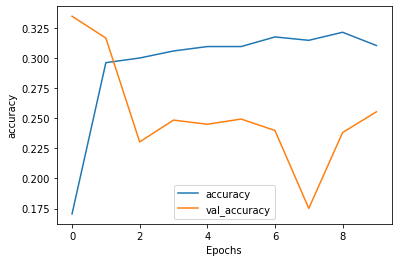

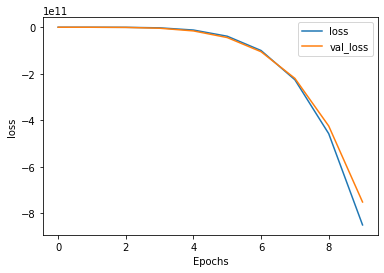

In [13]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = textcnnmodel.predict(Xcnn_train)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose = 1)

145/145 [==============================] - 4s 30ms/step - loss: -1140551450624.0000 - accuracy: 0.3694


In [15]:
print('Train Loss:', loss)
print('Train Accuracy:', accuracy, '(Model Metric)')
print('Train Accuracy:', accuracy_score(label_train, y_pred), '(sklearn Metric)')
print('Train Precision:', precision_score(label_train, y_pred))
print('Train Recall:', recall_score(label_train, y_pred))
print('Train F1-score:', f1_score(label_train, y_pred))

Train Loss: -1140551450624.0
Train Accuracy: 0.3693868815898895 (Model Metric)
Train Accuracy: 0.7247409326424871 (sklearn Metric)
Train Precision: 0.9732650739476678
Train Recall: 0.5821708063967336
Train F1-score: 0.728550138386204


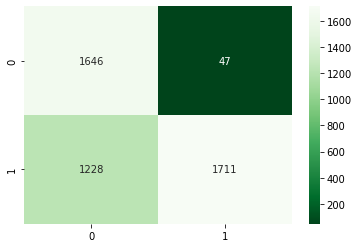

In [16]:
sns.heatmap(confusion_matrix(label_train, y_pred), annot = True, fmt = 'g', cmap='Greens_r')

In [17]:
y_pred = textcnnmodel.predict(Xcnn_test)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

Test Accuracy: 0.5893011216566005 (sklearn Metric)


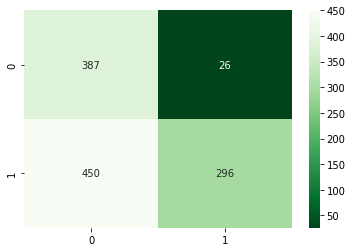

In [18]:
print('Test Accuracy:', accuracy_score(label_test, y_pred), '(sklearn Metric)')
sns.heatmap(confusion_matrix(label_test, y_pred), annot = True, fmt = 'g', cmap='Greens_r')

# BOW + NN

In [19]:
# get a word count per of text
def word_count(words):
    return len(words.split())

In [20]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)

{'more', 'did', "mustn't", 'where', 'herself', 'shan', 'yourselves', 'to', "won't", 'off', 'if', 'have', 'them', "weren't", 'only', 'own', 'does', "didn't", 'isn', 'you', 'that', 'here', "doesn't", 'himself', 'any', 'm', 'into', 'while', 'such', 'mustn', 'ours', 'aren', 'too', "mightn't", 'whom', 'were', 'most', 'y', "hadn't", 'up', 'in', 'ain', 'what', 'needn', 'of', 'again', 'each', 'both', "it's", 'from', 'themselves', 'is', 'about', 'the', 'when', 'yourself', 'no', 'can', "she's", 'being', 'do', "you've", 'my', 'your', 'has', 'at', 'until', 'having', "don't", "haven't", 'so', 'will', 'was', 'over', 'she', 'doing', "that'll", 'nor', 'which', 'all', 'o', 'weren', 'by', 'under', 'ourselves', 'not', 'won', 'those', 'mightn', 'his', "you'd", 'few', 'than', 'very', 'me', 'against', 'myself', 'their', 'our', 'above', 'or', 'on', "isn't", 'theirs', 'as', "should've", "wouldn't", 'but', 'it', 's', 'didn', 'him', 'hadn', 'why', 'ma', 'should', 'between', 'after', 'through', "shan't", 'doesn'

In [22]:
seed = 170204054
torch.manual_seed(seed)

In [23]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [24]:
#Checking if any null values present
(df.isnull().sum() / len(df))*100

Text         0.0
Sentiment    0.0
dtype: float64

In [25]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

In [26]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_text(text):
  # Lower Casing
    text = text.lower()
    text=text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    # Removing all @username.
    text = re.sub(userPattern,'',text) 
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(text)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwordSet]
    #reducing a word to its word stem 
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = ps.stem(w)
        finalwords.append(word)
    return ' '.join(finalwords)   

In [27]:
df['processed_text'] = df['Text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [28]:
print(df.shape)
df

(5791, 3)


,Text,Sentiment,processed_text
2064,OMX another bricks and mortar dinosaur falling...,0,mx anoth brick mortar dinosaur fall onlin reta...
5305,Many merchants still ask customers to sign for...,0,merchant still ask custom sign card purchas ra...
3875,OI SO XOM CPE IG -How does the price of oil Ve...,1,xom cpe ig price oil venezuela without chavez new
168,NVDA 4 hour - love to see the vol explode.,1,vda hour love see vol explod
382,"ANA with the conference tomorrow, I guess we w...",1,na confer tomorrow guess hit 1005
...,...,...,...
4113,"STI 5 min 1 - and 30 min opening range, added ...",1,ti min 30 min open rang ad call
47,c two daily bull flags on top of each other=b...,1,two daili bull flag top otherbullish still
5109,How Coronavirus Spread Through Corporate Ameri...,0,ow coronaviru spread corpor america
3478,CEG exactly what you want to see a stock do af...,1,eg exactli want see stock base consolid new high


In [29]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

#X = torch.from_numpy(X).type(torch.LongTensor)
#y = torch.from_numpy(y).type(torch.LongTensor)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [30]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [32]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [33]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

loss_fn = loss_fn.to(device)

In [34]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [35]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [36]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc  

In [37]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.013 | Train Acc: 1.47%
	 Val. Loss: 0.651 |  Val. Acc: 62.81%


In [38]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [39]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.729076790336497

In [40]:
prec=TP/(TP+FP)
prec

0.7178947368421053

In [41]:
rec=TP/(TP+FN)
rec

0.9368131868131868

In [42]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8128724672228844

# TF-IDF + NN

In [43]:
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [44]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [46]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [47]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [48]:
def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [49]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [50]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc

In [51]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.013 | Train Acc: 1.47%
	 Val. Loss: 0.650 |  Val. Acc: 62.81%


In [52]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [53]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.7238999137187231

In [54]:
prec=TP/(TP+FP)
prec

0.7125

In [55]:
rec=TP/(TP+FN)
rec

0.9395604395604396

In [56]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8104265402843602